In [2]:
import os
from random import sample as rsample
import numpy as np
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dense, Flatten
from keras.optimizers import SGD, RMSprop
from matplotlib import pyplot as plt
import json

Using TensorFlow backend.


In [3]:
GRID_SIZE = 15

In [4]:
def episode():
    """ 
    Coroutine function for an episode.     
        Action has to be explicitly sent (via "send") to this co-routine.
    """
    x, y, x_basket = (
        np.random.randint(0, GRID_SIZE),        # X of fruit
        0,                                      # Y of dot
        np.random.randint(1, GRID_SIZE - 1))    # X of basket
        
    while True:
        # Reset grid
        X = np.zeros((GRID_SIZE, GRID_SIZE))  
        # Draw the fruit in the screen
        X[y, x] = 1.
        # Draw the basket
        bar = range(x_basket - 1, x_basket + 2)
        X[-1, bar] = 1.
        
        # End of game is known when fruit is at penultimate line of grid.
        # End represents either the reward (a win or a loss)
        end = int(y >= GRID_SIZE - 2)
        if end and x not in bar:
            end *= -1

        action = yield X[np.newaxis], end
        if end:
            break

        x_basket = min(max(x_basket + action, 1), GRID_SIZE - 2)
        y += 1         

In [5]:
def experience_replay(batch_size):
    """
    Coroutine function for implementing experience replay.    
        Provides a new experience by calling "send", which in turn yields 
        a random batch of previous replay experiences.
    """
    memory = []
    while True:
        # experience is a tuple containing (S, action, reward, S_prime)
        experience = yield rsample(memory, batch_size) if batch_size <= len(memory) else None
        memory.append(experience)

def save_img():
    """
    Coroutine to store images in the "images" directory
    """
    if 'images' not in os.listdir('.'):
        os.mkdir('images')
    frame = 0
    while True:
        screen = (yield)
        plt.imshow(screen[0], interpolation='none')
        plt.xticks([])
        plt.yticks([])
        plt.title('{}'.format(frame))
        plt.savefig('images/%03i.png' % frame)
        frame += 1
        

In [6]:
nb_epochs = 50
batch_size = 128
epsilon = .8
gamma = .8

In [7]:
model = Sequential()
model.add(Convolution2D(16, kernel_size=(3,3), 
                        input_shape=(1, GRID_SIZE, GRID_SIZE), 
                        activation='relu',
                        data_format='channels_first'))

model.add(Convolution2D(16, kernel_size=(3,3), 
                        activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(3))
model.compile(RMSprop(), 'MSE')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 8, 8)          160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 6, 16)         1168      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1344)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               134500    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 136,131
Trainable params: 136,131
Non-trainable params: 0
_________________________________________________________________


In [8]:
#################
# RELOAD A MODEL
#################
# model = model_from_json(open('model.json').read())
# model.load_weights('model.h5')

exp_replay = experience_replay(batch_size)
next(exp_replay)  # Start experience-replay coroutine

for i in range(nb_epochs):
    ep = episode()
    S, reward = next(ep)  # Start coroutine of single entire episode
    loss = 0.
    try:
        while True:
            action = np.random.randint(-1, 2) 
            if np.random.random() > epsilon:
                # Get the index of the maximum q-value of the model.
                # Subtract one because actions are either -1, 0, or 1
                action = np.argmax(model.predict(S[np.newaxis]), axis=-1)[0] - 1

            S_prime, reward = ep.send(action)
            experience = (S, action, reward, S_prime)
            S = S_prime
            
            batch = exp_replay.send(experience)
            if batch:
                inputs = []
                targets = []
                for s, a, r, s_prime in batch:
                    # The targets of unchosen actions are the q-values of the model,
                    # so that the corresponding errors are 0. The targets of chosen actions
                    # are either the rewards, in case a terminal state has been reached, 
                    # or future discounted q-values, in case episodes are still running.
                    t = model.predict(s[np.newaxis]).flatten()
                    t[a + 1] = r
                    if not r:
                        t[a + 1] = r + gamma * model.predict(s_prime[np.newaxis]).max(axis=-1)
                    targets.append(t)
                    inputs.append(s)
                
                loss += model.train_on_batch(np.array(inputs), np.array(targets))

    except StopIteration:
        pass
    
    # if (i + 1) % 100 == 0:
    print('Epoch %i, loss: %.6f' % (i + 1, loss) )

Epoch 1, loss: 0.000000
Epoch 2, loss: 0.000000
Epoch 3, loss: 0.000000
Epoch 4, loss: 0.000000
Epoch 5, loss: 0.000000
Epoch 6, loss: 0.000000
Epoch 7, loss: 0.000000
Epoch 8, loss: 0.000000
Epoch 9, loss: 0.000000
Epoch 10, loss: 0.000000
Epoch 11, loss: 0.000000
Epoch 12, loss: 0.000000
Epoch 13, loss: 0.000000
Epoch 14, loss: 0.000000
Epoch 15, loss: 0.000000
Epoch 16, loss: 0.042020
Epoch 17, loss: 0.292145
Epoch 18, loss: 0.332925
Epoch 19, loss: 0.184429
Epoch 20, loss: 0.311543
Epoch 21, loss: 0.410605
Epoch 22, loss: 0.389618
Epoch 23, loss: 0.537128
Epoch 24, loss: 0.433184
Epoch 25, loss: 0.754993
Epoch 26, loss: 0.754196
Epoch 27, loss: 1.683500
Epoch 28, loss: 0.917693
Epoch 29, loss: 2.158868
Epoch 30, loss: 1.049633
Epoch 31, loss: 1.685290
Epoch 32, loss: 4.039494
Epoch 33, loss: 2.403280
Epoch 34, loss: 4.765786
Epoch 35, loss: 5.611214
Epoch 36, loss: 4.967581
Epoch 37, loss: 6.322775
Epoch 38, loss: 4.379163
Epoch 39, loss: 8.958813
Epoch 40, loss: 7.257718
Epoch 41,

In [9]:
#################
# SAVE THE MODEL
#################
# Save trained model weights and architecture, this will be used by the visualization code
model_name = "model.h5"
print("Saving the model to "+model_name)
json_string = model.to_json()
open('model.json', 'w').write(json_string)
model.save_weights(model_name)  

Saving the model to model.h5


Done.


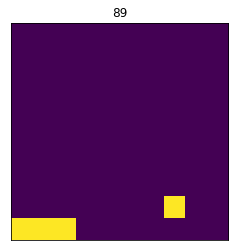

In [10]:
#################
# TEST
#################
img_saver = save_img()
next(img_saver)

for _ in range(10):
    g = episode()
    S, _ = next(g)
    img_saver.send(S)
    try:
        while True:
            act = np.argmax(model.predict(S[np.newaxis]), axis=-1)[0] - 1
            S, _ = g.send(act)
            img_saver.send(S)

    except StopIteration:
        pass

img_saver.close()
print('Done.')

In [11]:
# create gif
!convert -delay 20 -loop 0 images/*.png images/animation.gif

![Animation](images/animation.gif "animation")